In [1]:
import math
import matplotlib.pyplot as plt

import numpy as np
import numba as nb

%matplotlib notebook


/home/marcello/anaconda3/lib/python3.9/site-packages/numpy/_core/getlimits.py:545: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
@nb.njit(fastmath=True,cache=True)
def LJ( i, j, co2, pos, typ, cell, F ):
    
    E = 0.
    
    ti = typ[i]
    tj = typ[j]
    Eij = co2[ti][tj][0]
    sij = co2[ti][tj][1]
    sij2 = co2[ti][tj][2]
    
    rij = pos[i]-pos[j]
    
    if ( rij[0] > cell[0] ): # cell[0] = Lx/2
        rij[0] -= cell[1]    # cell[1] = Lx
    elif ( rij[0] < -cell[0] ):
        rij[0] += cell[1]
        
    if ( rij[1] > cell[2] ):
        rij[1] -= cell[3]
    elif ( rij[1] < -cell[2] ):
        rij[1] += cell[3]
    
    r2 = rij[0]*rij[0] + rij[1]*rij[1]
    
    if r2 > 0.:
        ir = 1. / np.sqrt(r2)
        rs = sij*ir
        rs2 = rs*rs
        rs6 = rs2*rs2*rs2
        rs12 = rs6*rs6
#        E = 4.*Eij*( (rs12) - (rs6) )
        F = 24.*Eij*ir * ( 2.*(rs12) - (rs6) ) * rij
    return F
#    return E,F,rij

@nb.njit(parallel=True, fastmath=True)
def compute_acc( N, co2, pos, typ, mas, acc, cell, ordered_idx, nat, off, Nx, Ny, bin_of_idx  ):
        
    F = np.zeros(D)
    
    for i in nb.prange(N):
        acc[i] = 0.

    for i in nb.prange(N):
        bin_xy = bin_of_idx[i]
        bin_y_idx = bin_xy % Ny
        bin_x_idx = (bin_xy - bin_y_idx) // Ny
        for other_bin_x in range( bin_x_idx-1,bin_x_idx+2 ):
            for other_bin_y in range( bin_y_idx-1,bin_y_idx+2 ):

                if other_bin_x == -1:
                    other_bin_x = Nx-1
                elif other_bin_x == Nx:
                    other_bin_x = 0
                if other_bin_y == -1:
                    other_bin_y = Ny-1
                elif other_bin_y == Ny:
                    other_bin_y = 0

                n_atom_in_other_bin = nat[other_bin_x][other_bin_y]
                fist_atom_in_other_bin = off[other_bin_x][other_bin_y]

                for j_idx in range(n_atom_in_other_bin):
                    j = ordered_idx[ fist_atom_in_other_bin + j_idx ]
                    if ( i < j ):
                        Fij = LJ( i, j, co2, pos, typ, cell, F )
                        acc[i] += Fij
                        acc[j] -= Fij

    for i in nb.prange(N):
        acc[i] = acc[i] * mas[i]
    
    return acc

@nb.njit(parallel=True, fastmath=True)
def pbc( N, pos, cell ):
    for i in nb.prange(N):
        if pos[i,0] > cell[1]:
            pos[i,0] -= cell[1]
        elif pos[i,0] < 0:
            pos[i,0] += cell[1]
        if pos[i,1] > cell[3]:
            pos[i,1] -= cell[3]
        elif pos[i,1] < 0:
            pos[i,1] += cell[3]
    return pos

@nb.njit(parallel=True, fastmath=True)
def limit_acc( N, acc, dt ):
    max_acc_norm2 = ( 0.1/dt )**2
    for i in nb.prange(N):
        acc_norm2 = acc[i,0]*acc[i,0] + acc[i,1]*acc[i,1]
        if acc_norm2 > max_acc_norm2 :
            fac = np.sqrt(max_acc_norm2 / acc_norm2)
            acc[i,0] *= fac
            acc[i,1] *= fac
    return acc

@nb.njit(parallel=True, fastmath=True)
def center_acc( N, acc ):
    ave_acc = np.sum(acc,axis=0) / N
    for i in nb.prange(N):
        acc[i] -= ave_acc[0]
    return acc

@nb.njit(parallel=True, fastmath=True)
def limit_vel( N, vel, dt ):
    max_vel_norm2 = ( 0.1/dt )**2
    for i in nb.prange(N):
        vel_norm2 = vel[i,0]*vel[i,0] + vel[i,1]*vel[i,1]
        if vel_norm2 > max_vel_norm2 :
            fac = np.sqrt(max_vel_norm2 / vel_norm2)
            vel[i,0] *= fac
            vel[i,1] *= fac
    return vel

@nb.njit(parallel=True, fastmath=True)
def center_vel( N, vel ):
    ave_vel = np.sum(vel,axis=0) / N
    for i in nb.prange(N):
        vel[i] -= ave_vel[0]
    return vel

@nb.njit(parallel=True, fastmath=True)
def balance_vel( N, vel, mas, desired_ave_ken ):
    
    sum_mas_vel2 = 0;
    for i in nb.prange(N):
        sum_mas_vel2 += mas[i]* (vel[i,0]*vel[i,0] + vel[i,1]*vel[i,1])
    
    ave_ken = 0.5 * sum_mas_vel2 / N
#    fac = np.sqrt(desired_ave_ken/ave_ken)
#    for i in nb.prange(N):
#        vel[i] *= fac

    return ave_ken

import itertools

def flatten_list(nested_list):
    return list(itertools.chain(*nested_list))



def find_interacting( N, pos, typ, cell, cutoff ):
    
    Lx = cell[1]
    Ly = cell[3]
    Nx = math.ceil(Lx / cutoff)
    Ny = math.ceil(Ly / cutoff)

    binned_idx = [ [ [] for i in range(Ny) ] for j in range(Nx) ]
    off = []
    nat = []
    
    
    bin_of_idx = np.zeros( N, dtype=int )
    for i in range(N):
        bin_x = math.floor (pos[i,0] / Lx * Nx)
        bin_y = math.floor (pos[i,1] / Ly * Ny)
        if bin_x >= Nx:
            print ( pos[i,0], Lx, bin_x, pos[i,0] / Lx * Nx )
        if bin_y >= Ny:
            print ( pos[i,1], Ly, bin_y, pos[i,1] / Ly * Ny )

        binned_idx[bin_x][bin_y].append(i)
        bin_of_idx[i] = bin_x * Ny + bin_y

    ordered_idx = flatten_list(flatten_list(binned_idx))
    
    tot_idx = 0
    for bin_x in range(Nx):
        for bin_y in range(Ny):
            n_idx = len(binned_idx[bin_x][bin_y])
            off.append( tot_idx )
            nat.append( n_idx )
            tot_idx += n_idx
    
    ordered_idx = np.array(ordered_idx)
    nat = np.array(nat).reshape((Nx,Ny))
    off = np.array(off).reshape((Nx,Ny))
    return ordered_idx, nat, off, Nx, Ny, bin_of_idx

@nb.njit(parallel=True)
def vV( N, pos, vel, acc, mas, typ, dt, cell, target_T, ordered_idx, nat, off, Nx, Ny, bin_of_idx ):

    for i in nb.prange(N):
        pos[i] += vel[i]*dt + 0.5*acc[i]*dt*dt
    
    pos = pbc(N, pos,cell)
    
    for i in nb.prange(N):
        vel[i] += 0.5*acc[i]*dt
    
    acc = compute_acc( N, co2, pos, typ, mas, acc, cell, ordered_idx, nat, off, Nx, Ny, bin_of_idx  )
    
    acc = limit_acc( N, acc, dt )
    acc = center_acc( N, acc )
    
    for i in nb.prange(N):
        vel[i] += 0.5*acc[i]*dt
    
    
    
    vel = limit_vel( N, vel, dt )
    vel = center_vel( N, vel )
    T = balance_vel( N, vel , mas, target_T )
    

(4096, 2)


<IPython.core.display.Javascript object>


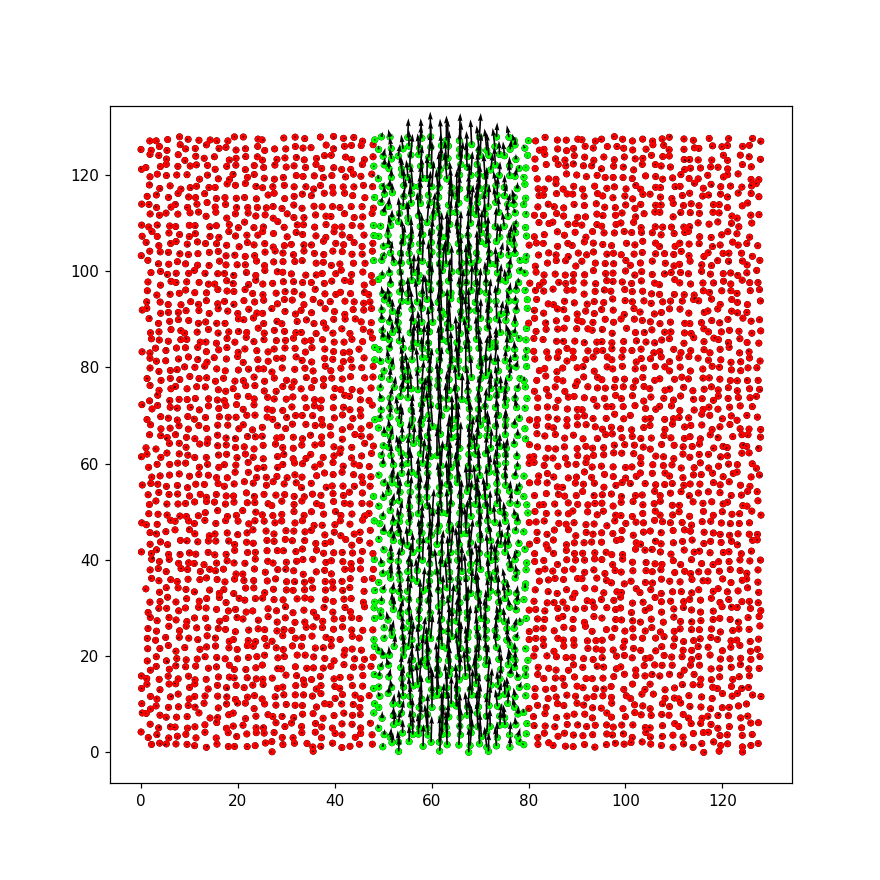

In [86]:
N = 64**2
D = 2
dt = 0.01
L = 2.*(N**(1./D))
cell = np.array([L/2.,L,L/2.,L])

kinds = [0,1]
mass_of_type = [1.,1.]


# Energy of the LJ
Ea = 1.0
Eb = 1.0
# Radius
Ra = 1.0
Rb = 1.0

co1 = [
    [Ea,Ra],
    [Eb,Rb]]
co1 = np.array(co1)
co1 = co1.reshape(2,2)

co2 = []
for t1 in co1:
    for t2 in co1:
        E1 = t1[0]
        E2 = t2[0]
        R1 = t1[1]
        R2 = t2[1]
        E12 = np.sqrt(E1*E2)
        R12 = (R1+R2)/2.
        co2.append([E12,R12,R12*R12])
co2 = np.array(co2)
co2 = co2.reshape(2,2,3)

pos = np.zeros(shape=(N,D))
vel = np.zeros(shape=(N,D))
acc = np.zeros(shape=(N,D))



nx, ny = (int(np.sqrt(N)), int(np.sqrt(N)))
x = np.linspace(0, 1, nx+1)[0:nx] + .5 / nx
y = np.linspace(0, 1, ny+1)[0:ny] + .5 / nx
pos = np.array(np.meshgrid(x, y)).T.reshape((-1,2))
pos += 0.01 * np.random.random( pos.shape )
pos *= L
pos = pbc(N, pos,cell)

vel = (np.random.random( vel.shape )-0.5)*2
vel *= 0.1

#typ = np.random.choice( kinds, N, True, [0.9,0.1] )
typ = np.zeros( N, int )
sel = []
sel = np.where( np.logical_and(pos[:,0] > 3*L/8, pos[:,0] < 5*L/8 ) )
vel[ sel, 1 ] += ( 1 - (64/L**2)*(pos[sel,0]-L/2)**2 )

#R = 10
#sel = np.where( (pos[:,0]-L/2)**2 + (pos[:,1]-L/2)**2 < R**2 )
#vel[ sel, 0 ] += (pos[sel,0]-L/2) * 0.05
#vel[ sel, 1 ] += (pos[sel,1]-L/2) * 0.05

typ[sel] = 1

# sort by radius, larger first
#rad = [co1[t][1] for t in typ]
#typ = np.array(sorted(typ, reverse=True))


mas = np.array([mass_of_type[t] for t in typ ])

size_of_type = [Ra, Rb ]
siz = np.array([size_of_type[t] for t in typ ])

print(pos.shape)

circle_fill_color = np.array([[1.0,0.0,0.0,1.0],[0.0,1.0,0.0,1.0]])
circle_brdr_color = np.array([[0.0,0.0,0.0,1.0],[0.0,0.0,0.0,1.0]])

fig = plt.figure(figsize=(8,8))
sc = (L / N * fig.figbbox.size[0])**2 * 0.02
plt.scatter(pos[:,0], pos[:,1], s=1.0*sc*siz**2, c=circle_brdr_color[typ])
plt.scatter(pos[:,0], pos[:,1], s=0.9*sc*siz**2, c=circle_fill_color[typ])
plt.quiver(pos[:,0],pos[:,1],vel[:,0],vel[:,1])
fig.canvas.draw()
fig.canvas.flush_events()

<IPython.core.display.Javascript object>


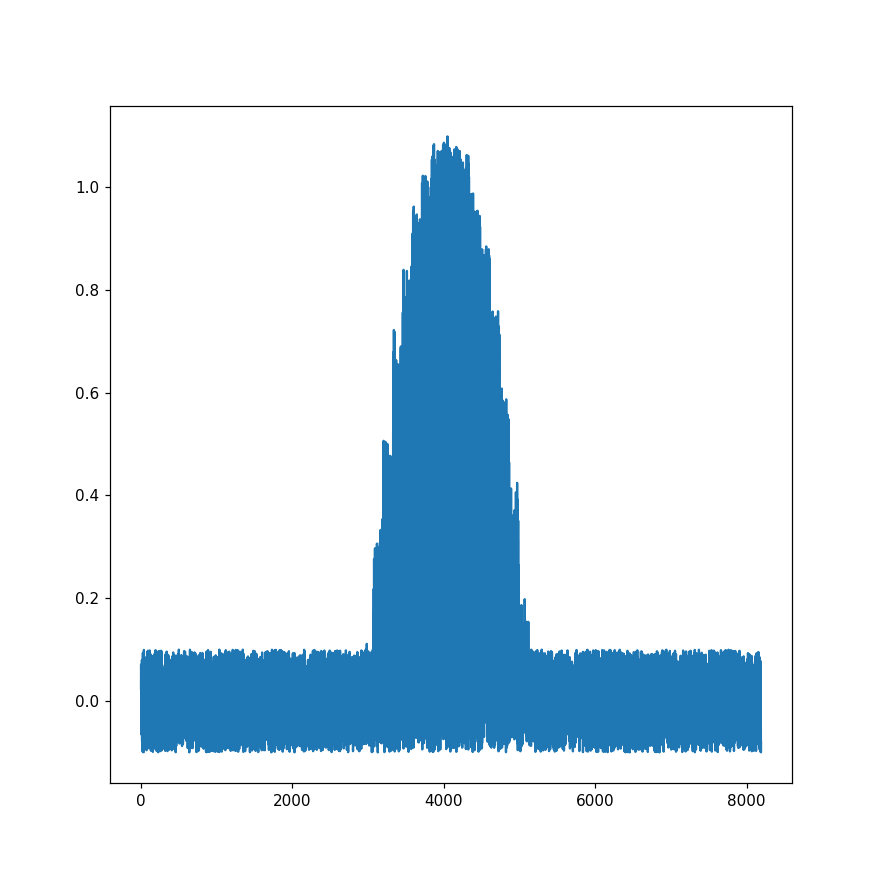

In [87]:
figure = plt.figure(figsize=(8,8))
ax = figure.add_subplot(111)
ax.plot(vel.flatten())
figure.canvas.draw()
figure.canvas.flush_events()

<IPython.core.display.Javascript object>


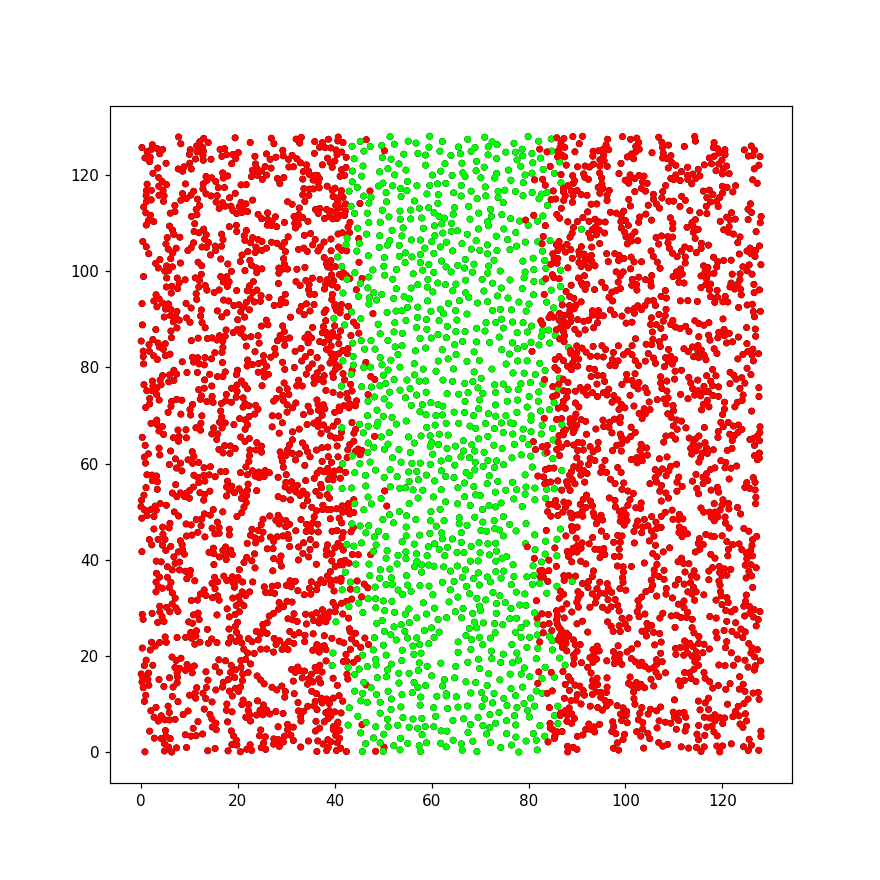

KeyboardInterrupt: 

In [89]:
figure = plt.figure(figsize=(8,8))
sc = (L / N * figure.figbbox.size[0])**2 * 0.02
ax = figure.add_subplot(111)
sp1 = ax.scatter(pos[:,0], pos[:,1], s=1.0*sc*siz**2, c=circle_brdr_color[typ])
sp2 = ax.scatter(pos[:,0], pos[:,1], s=0.9*sc*siz**2, c=circle_fill_color[typ])

t = 0
for ot in range(1000):
    target_T = 0.1 + 1.5 * np.sin( t * np.pi / 100 )**2
    for it in range(10):
        ordered_idx, nat, off, Nx, Ny, bin_of_idx = find_interacting( N, pos, typ, cell, 8. )        
        vV( N, pos, vel, acc, mas, typ, dt, cell, target_T, ordered_idx, nat, off, Nx, Ny, bin_of_idx )
        t += 1
        
    sp1.set_offsets( pos )
    sp2.set_offsets( pos )
    figure.canvas.draw()
    figure.canvas.flush_events()


<IPython.core.display.Javascript object>


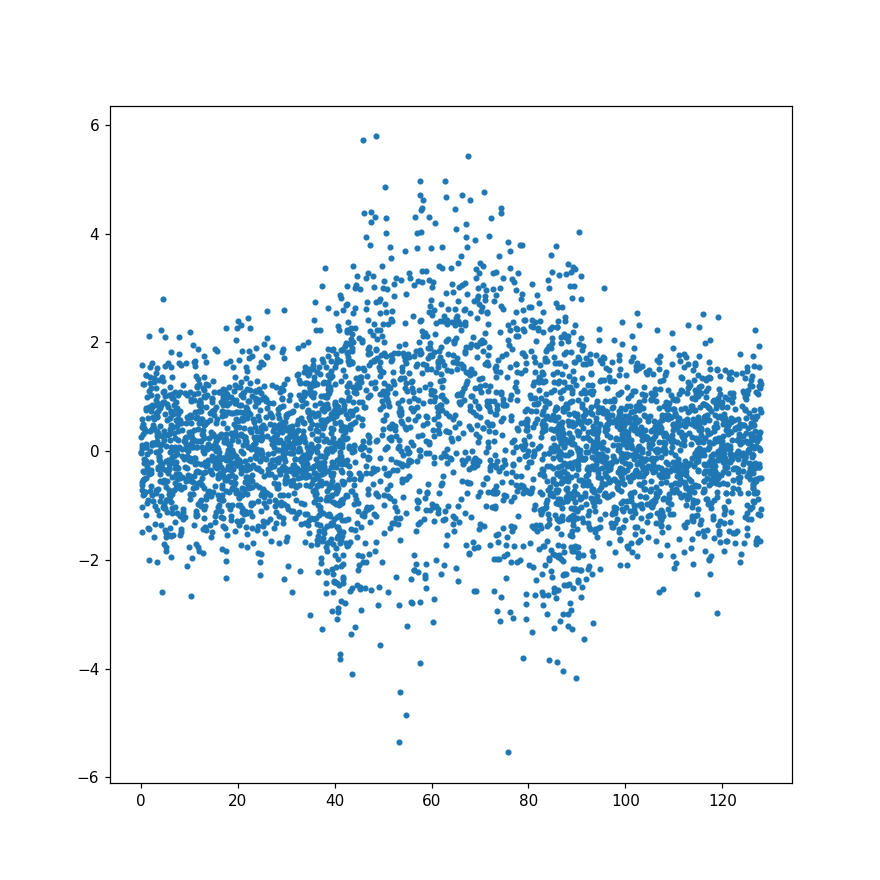

In [92]:
figure = plt.figure(figsize=(8,8))
ax = figure.add_subplot(111)
ax.plot(pos[:,0], vel[:,1].flatten(), '.')
figure.canvas.draw()
figure.canvas.flush_events()

In [17]:
all_pos = []
all_vel = []
all_acc = []
t = 0
for ot in range(20):
    target_T = 0.1 + 1.5 * np.sin( t * np.pi / 100 )**2
    for it in range(20):
        ordered_idx, nat, off, Nx, Ny, bin_of_idx = find_interacting( N, pos, typ, cell, 3. )        
        if t % 24 == 0 :
            %time vV( N, pos, vel, acc, mas, typ, dt, cell, target_T, ordered_idx, nat, off, Nx, Ny, bin_of_idx )
        else:
            vV( N, pos, vel, acc, mas, typ, dt, cell, target_T, ordered_idx, nat, off, Nx, Ny, bin_of_idx )
        t += 1
    all_pos.append(np.copy(pos))
    all_vel.append(np.copy(vel))
    all_acc.append(np.copy(acc))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.08 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.71 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.31 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.67 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.92 ms
CPU times: user 125 ms, sys: 0 ns, total: 125 ms
Wall time: 3.06 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.95 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.31 ms
Parser   : 125 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.24 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.28 ms
CPU times: user 125 ms, sys: 0 ns, total: 125 ms
Wall time: 4.87 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.4 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.34 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.45 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.52 ms
CPU times: user

<IPython.core.display.Javascript object>


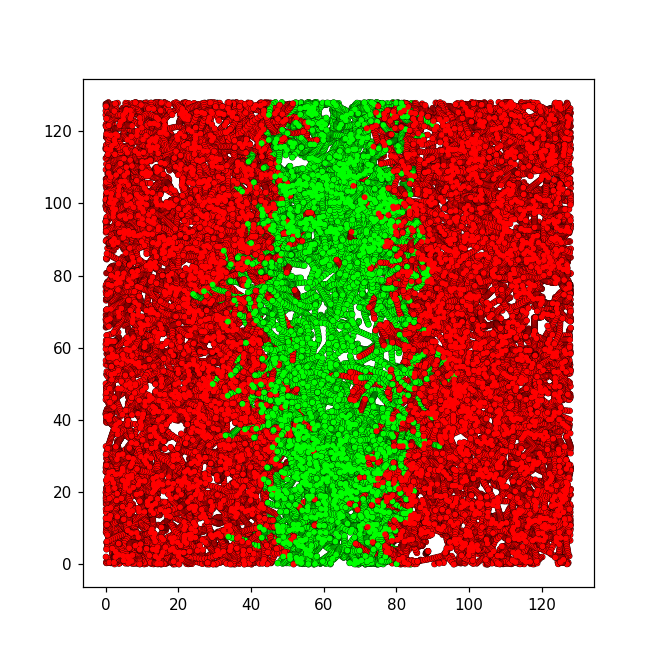

In [93]:
circle_fill_color = np.array([[1.0,0.0,0.0,1.0],[0.0,1.0,0.0,1.0]])
circle_brdr_color = np.array([[0.0,0.0,0.0,1.0],[0.0,0.0,0.0,1.0]])

fig = plt.figure(figsize=(6,6))

for pos in all_pos:
    plt.scatter(pos[:,0], pos[:,1], s=10*siz**2, c=circle_brdr_color[typ])
    plt.scatter(pos[:,0], pos[:,1], s=8*siz**2, c=circle_fill_color[typ])

In [ ]:
np.sum(mas[None,:,None]*all_vel,axis=1)